# This is implementation with pure Keras

## Has no automated feature selection. All features are passed to the model.

### Has shuffling, normalisation, udf for model training, reproducibility

Validation data is passed as some pct of the training data, for early stopping rounds. And then finally predictions are made on unseen test data.

In [1]:
# Load Keras libraries used in this example

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rn
from keras import backend as K
from sklearn.model_selection import train_test_split

# Loding data

In [3]:
all_data = pd.read_csv('data/train.csv')
all_data.shape

(1460, 81)

In [4]:
#separate the output column from the rest of your data
# prices=all_data['SalePrice']
# all_data.drop('SalePrice',axis=1,inplace=True)

In [4]:

# Dropping the id column
all_data.drop('Id',axis=1,inplace=True)

# all_data.drop('MSSubClass',axis=1,inplace=True)
all_data.shape

(1460, 80)

In [5]:
# #Feature selection should be done after data preprocessing.
# #Ideally  all the categorical variables should be encoded into numbers, so that we can assess how deterministic they are for target.
# #Currently we will be dealling with numerical columns only.
# colType = ['int64','float64']
# #Select the columns which are either int64 or float64.
# numCols=list(all_data.select_dtypes(include=colType).columns)
# #Assigning numerical columns from df to data variable. We can use the same variable as well.
# num_data=all_data[numCols]
# num_data.shape

In [6]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

# Handlig Missing values

In [8]:
all_data.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageType         81
GarageCond         81
GarageFinish       81
GarageQual         81
GarageYrBlt        81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
RoofMatl            0
Exterior1st         0
RoofStyle           0
ExterQual           0
Exterior2nd         0
YearBuilt           0
ExterCond           0
Foundation          0
YearRemodAdd        0
SalePrice           0
OverallCond         0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

In [9]:
# Dropping the features with majority null values

# So, we will remove Alley, PoolQC, Fence and MiscFeature
all_data.drop('Alley', axis=1, inplace=True)
all_data.drop('PoolQC', axis=1, inplace=True)
all_data.drop('Fence', axis=1, inplace=True)
all_data.drop('MiscFeature', axis=1, inplace=True)

In [10]:
#FireplaceQu
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('NF') # No fireplace

#LotFrontage
# all_data['LotFrontage'].mode() ---> 60
all_data['LotFrontage'] = all_data['LotFrontage'].fillna(60)

# Basement columns
for col in ['BsmtFinType2','BsmtExposure','BsmtQual','BsmtFinType1','BsmtCond']:
    all_data[col] = all_data[col].fillna('NB') # No basement

# Garage columns
for col in ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']:
    all_data[col] = all_data[col].fillna('NG') # No garage
    
# Dropping nans for the following cols
for col in ['MasVnrType','MasVnrArea','Electrical']:
    all_data.dropna(inplace=True)

In [11]:
all_data.isnull().sum().sort_values(ascending=False)

SalePrice        0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
SaleCondition    0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
RoofStyle        0
YearRemodAdd     0
YearBuilt        0
OverallCond      0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
                ..
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
GarageFinish     0
GarageType       0
CentralAir       0
FireplaceQu      0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath    

# Handling Categorical Columns

In [12]:
all_data1 = pd.get_dummies(all_data)

# Train Test Split

In [16]:
def split_train_test(df,label_col,test_size=0.2):
    
    X = df.loc[:,df.columns != label_col]
    y = df[label_col]

    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return train_x, test_x, train_y, test_y

In [17]:
train_x, test_x, train_y, test_y = split_train_test(all_data1,label_col='SalePrice')

In [18]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((1160, 382), (291, 382), (1160,), (291,))

# Create the model

Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [19]:
def build_model(train_x):
    
#     model = Sequential()
#     print('No of input features',train_x.shape[1])
#     model.add(Dense(128,activation="relu",input_shape=(train_x.shape[1],)))
#     model.add(Dense(64,activation="relu"))
#     model.add(Dense(1))
    
#     model.compile(loss='mean_squared_error',
#                     optimizer=RMSprop(lr=0.001),
#                     metrics=[metrics.mae])
#     print(model.summary())

    model = Sequential()
    BatchNormalization()
    model.add(Dense(1028,input_dim=train_x.shape[1],activation='relu'))
#     BatchNormalization()
#     model.add(Dense(1028,input_dim=train_x.shape[1],activation='relu'))
#     BatchNormalization()
    #Dropout(0.2)
    model.add(Dense(100,activation='relu'))
    BatchNormalization()
    #Dropout(0.2)
    model.add(Dense(50))
    BatchNormalization()
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse',metrics=[metrics.mae])
    return model

# Train the model

In [20]:
def model_train(model, train_x, train_y, epochs=500, batch_size=100,valid_pct=0.2, early_stopping_rounds = 20,verbose=0):
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_rounds)
    
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_split=valid_pct, verbose=verbose,
                    callbacks=[early_stop])
    
    [loss, mae] = model.evaluate(test_x, test_y, verbose=0)

    print("Testing set Mean Abs Error: {:7.2f}".format(mae))
    print("Testing set Root Mean Sqd Error : {:7.2f}".format((loss ** 0.5)))
    
    return loss,mae

In [28]:
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

model = build_model(train_x)

loss,mae = model_train(model=model, train_x=train_x, train_y=train_y, epochs=500, batch_size=128, valid_pct=0.2, early_stopping_rounds = 50, verbose=2)

Train on 928 samples, validate on 232 samples
Epoch 1/500
 - 0s - loss: 37233327563.0345 - mean_absolute_error: 175725.0016 - val_loss: 33102156694.0690 - val_mean_absolute_error: 165031.3475
Epoch 2/500
 - 0s - loss: 29006810288.5517 - mean_absolute_error: 151613.8095 - val_loss: 20480319064.2759 - val_mean_absolute_error: 124062.7837
Epoch 3/500
 - 0s - loss: 16598562533.5172 - mean_absolute_error: 100633.0598 - val_loss: 6249811314.7586 - val_mean_absolute_error: 55379.8311
Epoch 4/500
 - 0s - loss: 12525315531.0345 - mean_absolute_error: 55651.4993 - val_loss: 4134189585.6552 - val_mean_absolute_error: 45894.9616
Epoch 5/500
 - 0s - loss: 10303672655.4483 - mean_absolute_error: 50324.1557 - val_loss: 4039902402.2069 - val_mean_absolute_error: 43720.1181
Epoch 6/500
 - 0s - loss: 6895438583.1724 - mean_absolute_error: 46582.7349 - val_loss: 3802197618.7586 - val_mean_absolute_error: 42407.2216
Epoch 7/500
 - 0s - loss: 5616610824.8276 - mean_absolute_error: 44152.9716 - val_loss: 33

Epoch 58/500
 - 0s - loss: 2010072690.7586 - mean_absolute_error: 26889.6596 - val_loss: 1527899184.5517 - val_mean_absolute_error: 27267.7695
Epoch 59/500
 - 0s - loss: 2006518898.7586 - mean_absolute_error: 26764.2772 - val_loss: 1514322136.2759 - val_mean_absolute_error: 27175.4727
Epoch 60/500
 - 0s - loss: 1990513822.8966 - mean_absolute_error: 26671.5380 - val_loss: 1527907539.8621 - val_mean_absolute_error: 27279.0550
Epoch 61/500
 - 0s - loss: 1978086920.8276 - mean_absolute_error: 26641.4820 - val_loss: 1506733629.7931 - val_mean_absolute_error: 27090.2530
Epoch 62/500
 - 0s - loss: 1948704485.5172 - mean_absolute_error: 26683.6785 - val_loss: 1501758490.4828 - val_mean_absolute_error: 27008.9013
Epoch 63/500
 - 0s - loss: 1938812552.8276 - mean_absolute_error: 26453.2430 - val_loss: 1493519638.0690 - val_mean_absolute_error: 26914.7565
Epoch 64/500
 - 0s - loss: 1929423435.0345 - mean_absolute_error: 26566.7808 - val_loss: 1502103600.5517 - val_mean_absolute_error: 27046.0542

Epoch 116/500
 - 0s - loss: 1452028062.8966 - mean_absolute_error: 24810.3075 - val_loss: 1451027782.6207 - val_mean_absolute_error: 24842.2422
Epoch 117/500
 - 0s - loss: 1421941515.0345 - mean_absolute_error: 24480.1390 - val_loss: 1438226571.0345 - val_mean_absolute_error: 24971.2335
Epoch 118/500
 - 0s - loss: 1413176509.7931 - mean_absolute_error: 24590.9681 - val_loss: 1438715383.1724 - val_mean_absolute_error: 24562.1540
Epoch 119/500
 - 0s - loss: 1435784871.7241 - mean_absolute_error: 24808.1919 - val_loss: 1443775066.4828 - val_mean_absolute_error: 24601.1192
Epoch 120/500
 - 0s - loss: 1440638464.0000 - mean_absolute_error: 25048.8431 - val_loss: 1464203559.7241 - val_mean_absolute_error: 25759.7310
Epoch 121/500
 - 0s - loss: 1446335479.1724 - mean_absolute_error: 24951.7934 - val_loss: 1450108462.3448 - val_mean_absolute_error: 24539.6232
Epoch 122/500
 - 0s - loss: 1434616827.5862 - mean_absolute_error: 24666.1673 - val_loss: 1542450820.4138 - val_mean_absolute_error: 255

Epoch 173/500
 - 0s - loss: 1084731692.1379 - mean_absolute_error: 22477.4147 - val_loss: 1505992092.6897 - val_mean_absolute_error: 24147.5734
Epoch 174/500
 - 0s - loss: 1186546374.6207 - mean_absolute_error: 23871.2563 - val_loss: 1411648993.1034 - val_mean_absolute_error: 24113.7648
Epoch 175/500
 - 0s - loss: 1117320611.3103 - mean_absolute_error: 22654.6230 - val_loss: 1532017019.5862 - val_mean_absolute_error: 25784.0707
Epoch 176/500
 - 0s - loss: 1093289776.5517 - mean_absolute_error: 22548.4469 - val_loss: 1416309879.1724 - val_mean_absolute_error: 23819.6903
Epoch 177/500
 - 0s - loss: 1082459652.4138 - mean_absolute_error: 22523.4830 - val_loss: 1536492305.6552 - val_mean_absolute_error: 24825.4802
Epoch 178/500
 - 0s - loss: 1085045153.1034 - mean_absolute_error: 22633.4973 - val_loss: 1370490275.3103 - val_mean_absolute_error: 22606.6332
Epoch 179/500
 - 0s - loss: 1008681059.3103 - mean_absolute_error: 21417.2117 - val_loss: 1378702084.4138 - val_mean_absolute_error: 228

Epoch 231/500
 - 0s - loss: 760650994.7586 - mean_absolute_error: 18588.2094 - val_loss: 1278716288.0000 - val_mean_absolute_error: 20920.4603
Epoch 232/500
 - 0s - loss: 701742561.1034 - mean_absolute_error: 18005.8544 - val_loss: 1236066626.2069 - val_mean_absolute_error: 20599.2055
Epoch 233/500
 - 0s - loss: 719859414.0690 - mean_absolute_error: 18411.9247 - val_loss: 1321736326.6207 - val_mean_absolute_error: 21863.0869
Epoch 234/500
 - 0s - loss: 756911139.3103 - mean_absolute_error: 18641.9805 - val_loss: 1333159324.6897 - val_mean_absolute_error: 21590.7178
Epoch 235/500
 - 0s - loss: 743765764.4138 - mean_absolute_error: 18375.0414 - val_loss: 1274292376.2759 - val_mean_absolute_error: 21137.3908
Epoch 236/500
 - 0s - loss: 741889750.0690 - mean_absolute_error: 18599.2520 - val_loss: 1272040353.1034 - val_mean_absolute_error: 20747.2793
Epoch 237/500
 - 0s - loss: 768966520.8276 - mean_absolute_error: 19173.7848 - val_loss: 1270316599.1724 - val_mean_absolute_error: 20986.3105

Epoch 289/500
 - 0s - loss: 512535216.5517 - mean_absolute_error: 15934.3642 - val_loss: 1390859694.3448 - val_mean_absolute_error: 25212.5240
Epoch 290/500
 - 0s - loss: 650666323.8621 - mean_absolute_error: 18539.6850 - val_loss: 1276691314.7586 - val_mean_absolute_error: 22710.5591
Epoch 291/500
 - 0s - loss: 523027661.2414 - mean_absolute_error: 15975.8047 - val_loss: 1243341082.4828 - val_mean_absolute_error: 22980.6736
Epoch 292/500
 - 0s - loss: 567176131.3103 - mean_absolute_error: 16641.3574 - val_loss: 1108481595.5862 - val_mean_absolute_error: 19954.0044
Epoch 293/500
 - 0s - loss: 506655483.5862 - mean_absolute_error: 15897.0051 - val_loss: 1089380691.8621 - val_mean_absolute_error: 19762.6490
Epoch 294/500
 - 0s - loss: 553585824.0000 - mean_absolute_error: 16565.4884 - val_loss: 1309906266.4828 - val_mean_absolute_error: 23417.6496
Epoch 295/500
 - 0s - loss: 634234462.8966 - mean_absolute_error: 18153.8618 - val_loss: 1092168112.5517 - val_mean_absolute_error: 19713.3336

Epoch 347/500
 - 0s - loss: 407741313.1034 - mean_absolute_error: 14517.1262 - val_loss: 1138385946.4828 - val_mean_absolute_error: 21154.3069
Epoch 348/500
 - 0s - loss: 423571462.6207 - mean_absolute_error: 15080.3677 - val_loss: 1087367808.0000 - val_mean_absolute_error: 20808.5825
Epoch 349/500
 - 0s - loss: 445495343.4483 - mean_absolute_error: 15013.7483 - val_loss: 997047181.2414 - val_mean_absolute_error: 19279.3681
Epoch 350/500
 - 0s - loss: 403385603.3103 - mean_absolute_error: 14477.4417 - val_loss: 1178832801.1034 - val_mean_absolute_error: 22219.1146
Epoch 351/500
 - 0s - loss: 463580813.2414 - mean_absolute_error: 15387.3341 - val_loss: 979260484.4138 - val_mean_absolute_error: 19112.5154
Epoch 352/500
 - 0s - loss: 423553271.1724 - mean_absolute_error: 14919.7718 - val_loss: 976781248.0000 - val_mean_absolute_error: 18984.0246
Epoch 353/500
 - 0s - loss: 416583034.4828 - mean_absolute_error: 14611.6651 - val_loss: 968524791.1724 - val_mean_absolute_error: 18849.6768
Epo

Epoch 405/500
 - 0s - loss: 407892503.1724 - mean_absolute_error: 14756.7613 - val_loss: 1181785363.8621 - val_mean_absolute_error: 22511.1222
Epoch 406/500
 - 0s - loss: 450137756.6897 - mean_absolute_error: 15460.8185 - val_loss: 918888569.3793 - val_mean_absolute_error: 18823.2406
Epoch 407/500
 - 0s - loss: 456117466.4828 - mean_absolute_error: 15409.1424 - val_loss: 1158612078.3448 - val_mean_absolute_error: 21682.1232
Epoch 408/500
 - 0s - loss: 450967575.7241 - mean_absolute_error: 15330.0980 - val_loss: 967379824.5517 - val_mean_absolute_error: 19847.8522
Epoch 409/500
 - 0s - loss: 407894854.6207 - mean_absolute_error: 14476.0255 - val_loss: 1022514996.9655 - val_mean_absolute_error: 19970.0694
Epoch 410/500
 - 0s - loss: 416445325.2414 - mean_absolute_error: 14920.8494 - val_loss: 968079739.5862 - val_mean_absolute_error: 19193.2438
Epoch 411/500
 - 0s - loss: 361836445.7931 - mean_absolute_error: 13476.0457 - val_loss: 947372098.2069 - val_mean_absolute_error: 18863.6275
Epo

# Predicting on the Test data

In [29]:
test_predictions = model.predict(test_x).flatten()

In [30]:
predictions = pd.DataFrame(index=range(len(test_y)))
predictions['actual'] = pd.DataFrame(test_y.reset_index(drop=True))
predictions['preds'] = pd.DataFrame(test_predictions)

In [31]:
predictions

,actual,preds
0,315000,361139.343750
1,158900,160622.593750
2,127000,133328.968750
3,210000,209283.203125
4,260000,283038.062500
5,183200,209694.062500
6,185850,248431.703125
7,143500,143354.390625
8,165000,157876.765625
9,100000,131252.453125


In [32]:
# Mean and std of actual values in the test data.
predictions.actual.mean(), predictions.actual.std()

(179989.3883161512, 74821.7736464718)

In [33]:
# Percent error wrt to the mean actual price
print('Percent error: ',(loss ** 0.5)/predictions.actual.mean()*100,'%')

Percent error:  16.931628005491753 %


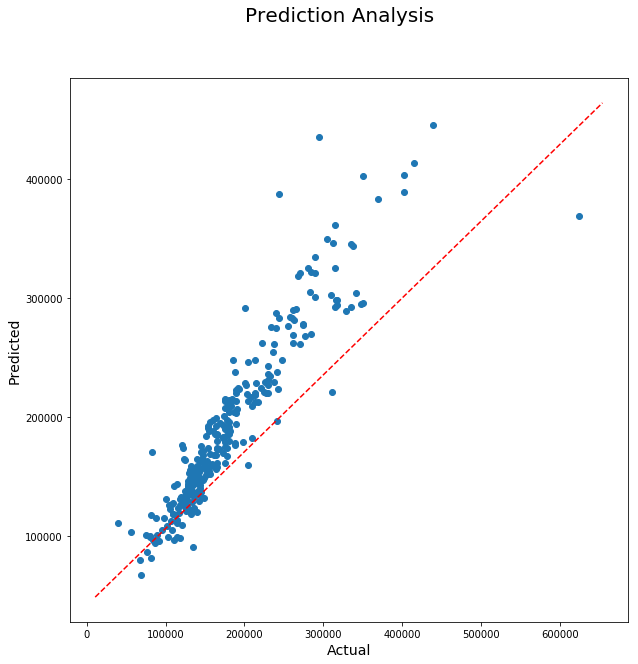

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(predictions.actual,predictions.preds)
fig.suptitle('Prediction Analysis', fontsize=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.show()

# Conclusion

The results are worse than the case when all features are not passed to the model